# CS166: Bus Simulation

In [1]:
# Importing the needed modules:
import numpy as np
import matplotlib.pyplot as plt 
import random
from scipy import stats

The following cell contains the bus stops names and the time that the bus takes to reach a specific stop. Students can customize these details as they want.

In [2]:
random.seed(1) 
bus_stops_names = ["Central Station", "Stop 1", "Stop 2", "Stop 3", "Stop 4", "Stop 5", "Stop 6", "Stop 7", 
                   "Stop 8", "Stop 9"]
travel_time = [random.randint(20, 30) for i in range(len(bus_stops_names))]# this gives the time the bus takes to reach
# a stop given that it must be coming from the stop before it. For example, travel_time[0] should be the time the bust 
#takes to reach the central station given that the bus is coming from stop 9.


In [3]:
class city_bus: 
    def __init__(self, bus_number, current_stop):
        self.current_stop = current_stop # the stop at which the bus is waiting
        self.next_stop = None # the next stop in the line
        self.maximum_passengers = 20 # the maximum capacity of the bus.
        self.passengers_number = 0 # to keep count of the total number of passengers per day
        self.passengers_list = [] # to keep track of which passengers in that bus
        self.bus_number = bus_number # just a name for each bus
        self.moving = False # Used to indicate if the bus is moving, will be used to update the state of the bus
        self.next_action_time = None #This will usually be the time the bus needs to arrive to the next stop
        # or the time it takes at each stop
    
    def get_next_stop_details(self):
        """
        A method to get the next stop for each bus and the time needed to reach the next stop.
        """
        next_stop = bus_stops_names[ (bus_stops_names.index(self.current_stop)+1)% len(bus_stops_names)]
        travel_time_needed = travel_time[bus_stops_names.index(next_stop)]
        travel_time_needed+= random.choice([-1, 0, 1]) # random value for traffic (can also be taken from norm 
        #distribution)
        return next_stop, travel_time_needed
        
    def move(self, current_time):
        """
        A method to update the status of the bus to start moving to its next stop
        Inputs: the time at which the bus started moving
        """
        self.moving = True
        next_stop, travel_time_needed = self.get_next_stop_details()
        self.next_stop = next_stop
        self.next_action_time = travel_time_needed + current_time # the bus status will be updated after this time
        # which is the time that it needs to reach the next stop.
       
        if verbose: # verbose is usually set to False so printing is turned off.
            print(f"At time step {current_time}, Bus {self.bus_number} is moving towards {self.next_stop} with\
            {len(self.passengers_list)} passengers")
    
    def stop_and_wait(self, current_time):
        """
        A method to update the bus status to stop and wait once it reaches the stop.
        """    
        self.moving = False
        self.current_stop = self.next_stop # since it has already reached its next stop
        self.next_action_time = current_time+ 2 # the bus waits only 2 minuts at each station
        self.load_and_unload(current_time) #start unloading the passengers and load new passengers


    def load_and_unload(self, current_time):
        """
         A method to let the bus unload passengers and load new passengers
        """
        if verbose:
            print(f"At time step {current_time}, Bus {self.bus_number} arrived to {self.current_stop}")
        #unloading
        for passenger in self.passengers_list:
            if passenger.destination == self.current_stop:
                self.passengers_list.remove(passenger)
                if verbose:
                    print(f"Bus {self.bus_number} is unloading passengers...")
        #loading
        
        current_stop_object = bus_stops_objects[bus_stops_names.index(self.current_stop)] #the stop where the bus is 
        #waiting
        if verbose:    
            print(f"the station has {len(current_stop_object.passengers_list)} passengers")
        
        # Load passengers until the maximum capacity:
        while len(self.passengers_list) < self.maximum_passengers and len(current_stop_object.passengers_list) >0:
            passenger = current_stop_object.passengers_list.pop(0)#passenger leaving the stop
            self.passengers_list.append(passenger) #entering the bus
            self.passengers_number+=1 # counting the number of passengers that each bus take
            passenger.waiting = False
            
            # the passenger's waiting time is the bus's arrival time minus the time at which the passenger
            #arrived to the station
            passenger.waiting_time = current_time - passenger.arrival_time
            
            waiting_times.append(passenger.waiting_time) # appending this for the analysis
              
            if verbose:    
                print(f"Bus {self.bus_number} is loading passengers")


class city_passenger:
    def __init__(self, current_stop, destination, arrival_time):
        self.current_stop = current_stop # stop at which the passenger waits
        self.destination = destination # the stop at which the passenger needs to go
        self.waiting = True
        self.arrival_time = arrival_time # the time at which the passenger arrives to the stop
        self.waiting_time = 0 # Bus's arrival minus passenger's arrival
        
class bus_stop:
    def __init__(self, name):
        self.name = name
        self.passengers_list = [] 
        self.waiting_busses = [] 

In [4]:
def passengers_random_arrival(arrival_time, bus_stops_objects):
    """
    A function to generate passengers randomly at the bus stops.
    Every 5 minutes, this function will be called. Once it gets called, there is a 5% chance that a passenger will be 
    assigned to a specific bus stop.
    """
    
    for bus_stop in bus_stops_objects:
        if random.uniform(0, 1) < 0.05: 
            
            # the destination of the passenger is chosen randomly
            passenger = city_passenger(bus_stop.name, 
                        random.choice([i for i in bus_stops_names if i != bus_stop.name]), arrival_time)
            bus_stop.passengers_list.append(passenger)
            

## Starting the Simulation:
I consider each time step to be equal to 1 minute. I then run the simulation for 1440 steps which is equal to one day. I run 100 days to generate confidence intervals.

In [24]:
verbose = False # set to True only if you want to see the print statements (it's better to check the tracking screen
# attached in the report).



#Trying different time intervals between buses to find the best:
time_intervals = [1, 5, 8, 11, 15, 19, 23, 27, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]


time_per_interval = [] #this will contain the average waiting times for each interval

variance_per_interval = [] #this will contain the variance in the total number of passengers of the busses

city_buses_num = 8 # total number of available buses


for time_interval in time_intervals: 
    averager = []
    variancer = []
    for day in range(100): #running 100 days for each time interval
        ###
        bus_stops_objects = [bus_stop(i) for i in bus_stops_names]
        city_buses = [city_bus(i+1, "Central Station") for i in range(city_buses_num)]
        ###
        buses_out = 0 # I start with all the buses at the central station and send them out every time interval
        # untill all busse are sent out
        
        waiting_times = []
        for time_step in range(1440): #each day is 1440 minutes:
            if time_step % 5 ==0: #adding passengers randomly every 5 minutes
                passengers_random_arrival(time_step, bus_stops_objects)
                
                
            #sending a bus out of the central station every time_interval until all of them are working    
            if buses_out < len(city_buses) and time_step % time_interval ==0:
                city_buses[buses_out].move(time_step)
                buses_out+=1
          
            for bus in city_buses: #update the state of the bus
                if time_step == bus.next_action_time: 
                    if bus.moving: # if the bus arrived to the stop
                        bus.stop_and_wait(time_step)

                    else: #or if the bus finished loading passengers
                        bus.move(time_step)  
    
        averager.append(np.mean(waiting_times))
        variancer.append(np.var([i.passengers_number for i in city_buses]))
    time_per_interval.append(averager)
    variance_per_interval.append(variancer)

## The Analysis:
Since this is an optimization problem, the main goal is to find the time interval that will minimize the average waiting time and keep a sufficent number of passengers per bus. So students need to measure two main values:
- The average waiting time
- The number of people that each bus serves over the day. Students can do this in many different ways. Some might choose to keep track of the total number of passengers that each bus serves per day and then look at the minimum number of these, other students can look at the average number of passengers over the day. Here, I kept track of the total number of passengers that each bus served in one day and then I took the variance of these numbers. Ideally, we want the variance to be as minimum as possible to indicate that all the buses serve equal number of passengers (no bus works more than the others).

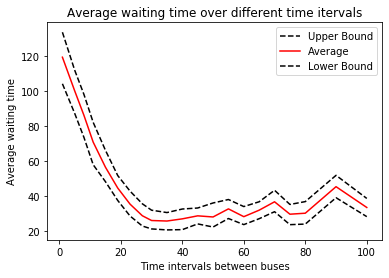

In [25]:
plt.plot(time_intervals, [np.quantile(i, 0.975) for i in time_per_interval], '--', color = 'black', label = 'Upper Bound')
plt.plot(time_intervals, [np.mean(i) for i in time_per_interval], color = 'red', label = 'Average')
plt.plot(time_intervals, [np.quantile(i, 0.025) for i in time_per_interval], '--', color = 'black', label='Lower Bound')
plt.xlabel("Time intervals between buses")
plt.ylabel("Average waiting time")
plt.title("Average waiting time over different time itervals")
plt.legend()
plt.show()

In [26]:
min_time = np.min([np.mean(i) for i in time_per_interval])
min_step = time_intervals[np.argmin([np.mean(i) for i in time_per_interval])]
print(f"Time Interval: {min_step}, Average Wainting Time: {min_time}")

Time Interval: 35, Average Wainting Time: 25.874565170579885


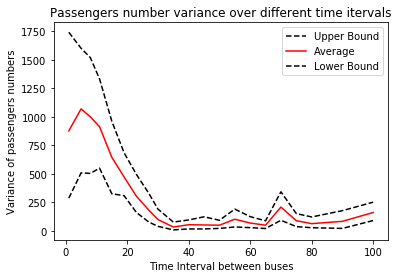

In [21]:
plt.plot(time_intervals, [np.quantile(i, 0.975) for i in variance_per_interval], '--', color = 'black', label="Upper Bound")
plt.plot(time_intervals, [np.mean(i) for i in variance_per_interval], color = 'red', label = "Average")
plt.plot(time_intervals, [np.quantile(i, 0.025) for i in variance_per_interval], '--', color = 'black', label= "Lower Bound")
plt.ylabel("Variance of passengers numbers")
plt.xlabel("Time Interval between buses")
plt.title("Passengers number variance over different time itervals")
plt.legend()
plt.show()

In [22]:
min_var = np.min([np.mean(i) for i in variance_per_interval])
min_step = time_intervals[np.argmin([np.mean(i) for i in variance_per_interval])]
print(f"Time Interval: {min_step}, Variance: {min_var}")

Time Interval: 35, Variance: 32.4996875


In [30]:
verbose = False # set to True only if you want to see the print statements (it's better to check the tracking screen
# attached in the report).



#Trying different time intervals between buses to find the best:
time_intervals = [1, 5, 8, 11, 15, 19, 23, 27, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]




city_buses_num_list = [2, 4, 6, 8, 10, 12, 14, 16, 17]

intervals_for_buses = []
variance_for_buses = []
for city_buses_num in city_buses_num_list:
    variance_per_interval = [] #this will contain the variance in the total number of passengers of the busses
    time_per_interval = [] #this will contain the average waiting times for each interval

    for time_interval in time_intervals: 
        averager = []
        variancer = []
        for day in range(50): #running 100 days for each time interval
            ###
            bus_stops_objects = [bus_stop(i) for i in bus_stops_names]
            city_buses = [city_bus(i+1, "Central Station") for i in range(city_buses_num)]
            ###
            buses_out = 0 # I start with all the buses at the central station and send them out every time interval
            # untill all busse are sent out

            waiting_times = []
            for time_step in range(1440): 
                
                if time_step % 5 ==0: #adding passengers randomly every 5 minutes
                    passengers_random_arrival(time_step, bus_stops_objects)


                #sending a bus out of the central station every time_interval until all of them are working    
                if buses_out < len(city_buses) and time_step % time_interval ==0:
                    city_buses[buses_out].move(time_step)
                    buses_out+=1

                for bus in city_buses: #update the state of the bus
                    if time_step == bus.next_action_time: 
                        if bus.moving: # if the bus arrived to the stop
                            bus.stop_and_wait(time_step)

                        else: #or if the bus finished loading passengers
                            bus.move(time_step)  

            averager.append(np.mean(waiting_times))
            variancer.append(np.var([i.passengers_number for i in city_buses]))
        time_per_interval.append(averager)
        variance_per_interval.append(variancer)
        
        
    intervals_for_buses.append(time_per_interval)
    variance_for_buses.append(variance_per_interval)


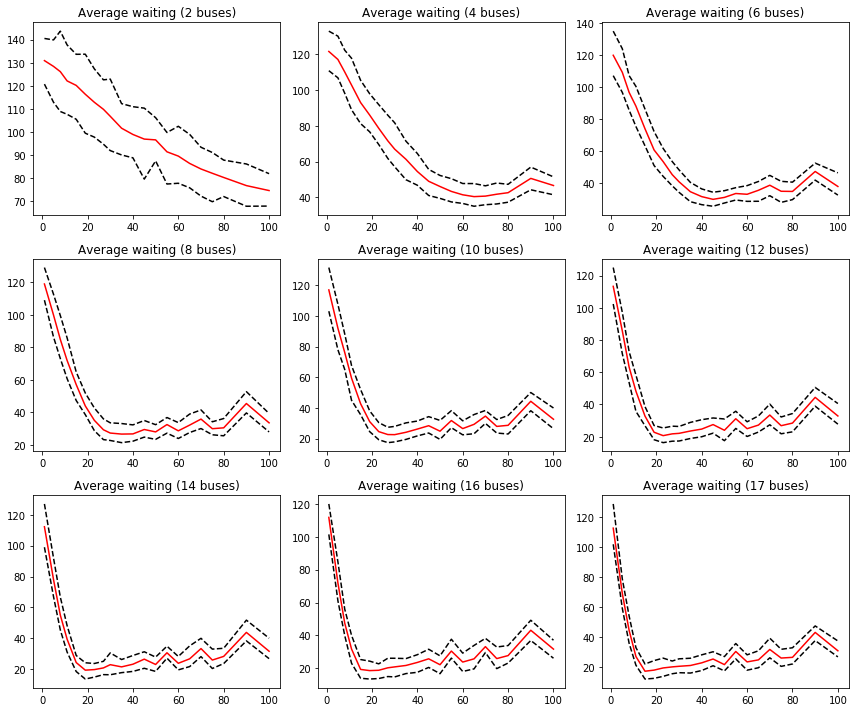

In [31]:
index = 5
plt.subplots(3, 3, figsize=(12,10))
for index in range(len(city_buses_num_list)):
    plt.subplot(3, 3, index+1)
    plt.plot(time_intervals, [np.quantile(i, 0.975) for i in intervals_for_buses[index]], '--', color = 'black', label = 'Upper Bound')
    plt.plot(time_intervals, [np.mean(i) for i in intervals_for_buses[index]], color = 'red', label = 'Average')
    plt.plot(time_intervals, [np.quantile(i, 0.025) for i in intervals_for_buses[index]], '--', color = 'black', label='Lower Bound')
    #plt.xlabel("Time intervals between buses")
    #plt.ylabel("Average waiting time")
    plt.title(f"Average waiting ({city_buses_num_list[index]} buses)")
#plt.legend()
plt.tight_layout()
plt.show()

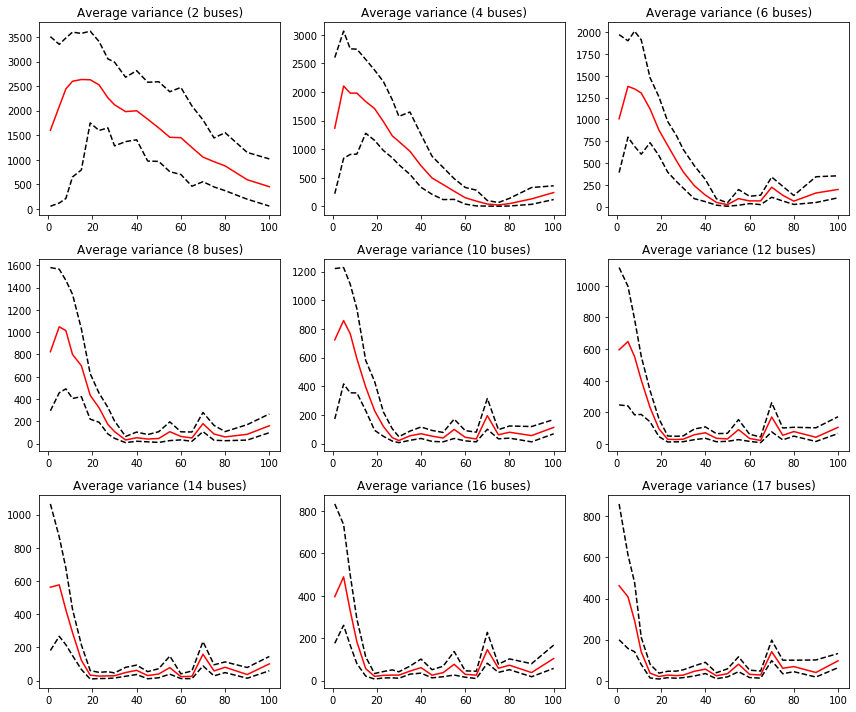

In [32]:
index = 5
plt.subplots(3, 3, figsize=(12,10))
for index in range(len(city_buses_num_list)):
    plt.subplot(3, 3, index+1)
    plt.plot(time_intervals, [np.quantile(i, 0.975) for i in variance_for_buses[index]], '--', color = 'black', label = 'Upper Bound')
    plt.plot(time_intervals, [np.mean(i) for i in variance_for_buses[index]], color = 'red', label = 'Average')
    plt.plot(time_intervals, [np.quantile(i, 0.025) for i in variance_for_buses[index]], '--', color = 'black', label='Lower Bound')
    #plt.xlabel("Time intervals between buses")
    #plt.ylabel("Average waiting time")
    plt.title(f"Average variance ({city_buses_num_list[index]} buses)")
#plt.legend()
plt.tight_layout()
plt.show()

In [13]:
verbose = False # set to True only if you want to see the print statements (it's better to check the tracking screen
# attached in the report).



#Trying different time intervals between buses to find the best:
time_intervals = [1, 5, 8, 11, 15, 19, 23, 27, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100]


time_per_interval = [] #this will contain the average waiting times for each interval

variance_per_interval = [] #this will contain the variance in the total number of passengers of the busses

city_buses_num = 8 # total number of available buses


for time_interval in time_intervals: 
    averager = [[], [], [], []]
    for day in range(100): #running 100 days for each time interval
        ###
        bus_stops_objects = [bus_stop(i) for i in bus_stops_names]
        city_buses = [city_bus(i+1, "Central Station") for i in range(city_buses_num)]
        ###
        buses_out = 0 # I start with all the buses at the central station and send them out every time interval
        # untill all busse are sent out
        
        waiting_times = []
        for time_step in range(1440): 
            
            if time_step >= 0 and time_step < 360:
                if time_step % 90 ==0: 
                    passengers_random_arrival(time_step, bus_stops_objects)

            elif time_step >= 360 and time_step < 720:
                if time_step == 360:
                    if waiting_times:
                        averager[0].append(np.mean(waiting_times))
                    waiting_times = []
                if time_step % 5 ==0: 
                    passengers_random_arrival(time_step, bus_stops_objects)

            elif time_step >= 720 and time_step < 1080:
                if time_step == 720:
                    if waiting_times:
                        averager[1].append(np.mean(waiting_times))
                    waiting_times = []
                if time_step % 40 ==0: 
                    passengers_random_arrival(time_step, bus_stops_objects)

            elif time_step >= 1080:
                if time_step == 1080:
                    if waiting_times:
                        averager[2].append(np.mean(waiting_times))
                    waiting_times = []
                if time_step % 5 ==0: 
                    passengers_random_arrival(time_step, bus_stops_objects)


                
                
            #sending a bus out of the central station every time_interval until all of them are working    
            if buses_out < len(city_buses) and time_step % time_interval ==0:
                city_buses[buses_out].move(time_step)
                buses_out+=1
          
            for bus in city_buses: #update the state of the bus
                if time_step == bus.next_action_time: 
                    if bus.moving: # if the bus arrived to the stop
                        bus.stop_and_wait(time_step)

                    else: #or if the bus finished loading passengers
                        bus.move(time_step)  
    
        averager[3].append(np.mean(waiting_times))
        variancer.append(np.min([i.passengers_number for i in city_buses]))
    time_per_interval.append(averager)
    variance_per_interval.append(variancer)

In [14]:
p1 = [np.mean(i[0]) for i in time_per_interval]
p2 = [np.mean(i[1]) for i in time_per_interval]
p3 = [np.mean(i[2]) for i in time_per_interval]
p4 = [np.mean(i[3]) for i in time_per_interval]

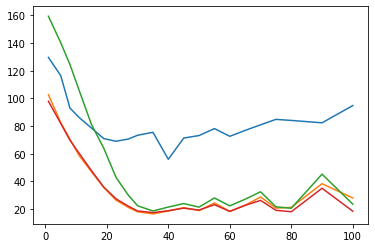

In [15]:
plt.plot(time_intervals, p1)
plt.plot(time_intervals, p2)
plt.plot(time_intervals, p3)
plt.plot(time_intervals, p4)